<a href="https://colab.research.google.com/github/joaopmt/CS-classes-projects/blob/master/mc886-machine-learning/project1/linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment \#1**: Machine Learning MC886
University of Campinas (UNICAMP), Institute of Computing (IC)

Prof. Sandra Avila, 2020s2



In [ ]:
# TODO: RA & Name 
print('176117: ' + 'João Pedro Martins')
print('185531: ' + 'Pedro Alan Tapia Ramos')

print('IMPORTANT: In order to run the code you first need to upload the two data sets inside the \"content\" folder (default folder)')

176117: João Pedro Martins
185531: Pedro Alan Tapia Ramos
IMPORTANT: In order to run the code you first need to upload the two data sets inside the "content" folder (default folder)


## Objective 

Explore **linear regression** alternatives and come up with the best possible model to the problems, avoiding overfitting. In particular, predict the **price of diamonds** from their attributes (e.g., depth, clarity, color) using the Diamonds dataset (https://www.kaggle.com/shivam2503/diamonds)

## Dataset

The Diamonds dataset contains the prices and attributes of almost 50,000 diamonds.

Dataset Information: You should respect the following traininig/test split: 45,000 training examples, and 5,000 test examples.

There are 9 attributes as follows: 

- 1: **carat**: weight of the diamond (0.2-5.01)
- 2: **cut**: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- 3: **color**: diamond color, from J (worst) to D (best)
- 4: **clarity**: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
- 5: **x**: length in mm (0-10.74)
- 6: **y**: width in mm (0-58.9)
- 7: **z**: depth in mm (0-31.8)
- 8: **depth**: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43-79)
- 9: **table**: width of top of diamond relative to widest point (43-95)


target **price**: price in US dollars

The data is available at
https://www.dropbox.com/s/tmz8bkocrpfmfb9/diamonds-dataset.zip


## Deadline

Monday, October 12th 7 pm. 

Penalty policy for late submission: You are not encouraged to submit your assignment after due date. However, in case you did, your grade will be penalized as follows:
- October 13th 7 pm : grade * 0.75
- October 14th 7 pm : grade * 0.5
- October 15th 7 pm : grade * 0.25


## Submission

On Google Classroom, submit your Jupyter Notebook (in Portuguese or English).

**This activity is NOT individual, it must be done in pairs (two-person group).**

## Activities

1. (4 points) Perform Linear Regression. You should implement your solution and compare it with ```sklearn.linear_model.SGDRegressor``` (linear model fitted by minimizing a regularized empirical loss with SGD, http://scikit-learn.org). Keep in mind that friends don't let friends use testing data for training :-)



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from timeit import default_timer as timer
from sklearn.metrics import mean_squared_error
%matplotlib inline

learning_rate = 1e-6

# Function that will be used to preprocess a dataframe. Most important results
# will be condesing columns and applying values to categorical features
def preprocess_df(df):
  # Add volume column.
  df['volume'] = df['x']*df['y']*df['z']

  # Remove x, y, z, depth, and table columns. They are closely related to volume.
  del df['x']
  del df['y']
  del df['z']
  del df['depth']
  del df['table']

  # Rearrange columns so that price is last.
  df = df[['carat', 'cut', 'color', 'clarity', 'volume', 'price']]

  # Encoding for categorical features. Note: using methods like `apply` is way
  # faster than iterating over the df rows. Ideally, we should never iterate over df.
  cut = {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}
  color = {'J': 1, 'H': 2, 'I': 3, 'G': 4, 'F': 5, 'E': 6, 'D': 7}
  clarity = {'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8}
  df['cut'] = df['cut'].apply(lambda x: cut[x])
  df['color'] = df['color'].apply(lambda x: color[x])
  df['clarity'] = df['clarity'].apply(lambda x: clarity[x])

  return df

# Somatory util used by the batch regressor. It iterates through all data 
def somatory(param, params, df, hypothesis):
  s = 0
  for index, row in df.iterrows():
    s += (hypothesis(row, params) - row['price'])*row.get(param, 1)
    
  return s

# Batch gradient descent function
def batch_regressor(params, df, hypothesis):
  m = len(df.index)
  new_params = {}
  for key, value in params.items():
    new_params[key] = value - (learning_rate / m) * somatory(key, params, df, hypothesis)
  return new_params

# Stochastic gradient descent function
def stochastic_regressor(params, df, hypothesis):
  m = len(df.index)
  # Selects a row.
  for index, row in df.iterrows():
    new_params = {}
    # Update all params using the row.
    for param, value in params.items():
      new_params[param] = value - learning_rate * (hypothesis(row, params) - row['price']) * row.get(param, 1)
    params = new_params
  return new_params

# Returns the R2 for the model.
def r_squared(params, price_mean, df, hypothesis):
  s_tot = df.apply(lambda x: (x['price'] - price_mean)**2, axis=1).values.sum()
  s_res = df.apply(lambda x: (x['price'] - hypothesis(x, params))**2, axis=1).values.sum()
  return 1 - s_res/s_tot

# Given a data frame, a function hypothesis and the dicionary containg the theta values (params),
# applies the hypothesis to each row and return the resulting array
def predict(df, hypothesis, params):
  return df.apply(lambda x: hypothesis(x, params), axis=1).values

# Trains the model, using regressor as the type of regression that will be made at each,
# epoch. It uses hypothesis as the model function and it updates the given dictionary
# of params (aka. the theta values).
# You can choose to log each epoch's R^2 value and list of updated params by setting
# log_epochs=True.
def fit(params, df, regressor, hypothesis, epochs=10, log_epochs=False):
  price_mean = df['price'].mean()
  
  if log_epochs:
    print('Training R^2:')

  for i in range(epochs):
    if log_epochs:
      print(' Epoch:', i)
      print('  Params:', params)
      print('  R^2:', r_squared(params, price_mean, df, hypothesis))
    params = regressor(params, df, hypothesis)

  if log_epochs:
    print('Final Training R^2:', r_squared(params, price_mean, df, hypothesis))

  return params

# Returns the R^2 core for the given dataframe, given the hypothesis and its params. 
def score(params, df, hypothesis):
  price_mean = df['price'].mean()
  return r_squared(params, price_mean, df, hypothesis)

# Return value of mean squared error given the real array of Y and the predicted array
def cost(y_real, y_pred):
  s = 0
  for y_r, y_p in zip(y_real, y_pred):
    s += (y_r - y_p)**2
  return s / len(y_real)

In [ ]:
# Prepare training data.
df = pd.read_csv("diamonds-train.csv")
df = preprocess_df(df)
print(df)

# Define initial params values.
params = {'teta0': 1.0}
for col in df:
  if col == 'price':
    continue
  params[col] = 1.0

# Define the function hypothesis
def h(row, params):
  # h_teta(x) = teta0 + teta1*carat + teta2*cut + teta3*color + teta3*clarity + teta4*volume
  return params['teta0'] + row['carat']*params['carat']  \
    + row['cut']*params['cut'] + row['color']*params['color'] \
    + row['clarity']*params['clarity'] + row['volume']*params['volume']

regressor = stochastic_regressor # You can choose between stochastic_regressor and batch_regressor
hypothesis = h
epochs = 10

# Train.
print('Training...')
start = timer()
params = fit(params, df, regressor, hypothesis, epochs, log_epochs=False)
end = timer()
print('Elapsed training time (our solution): ', end - start, ' seconds.')

# Prepare test data.
df = pd.read_csv("diamonds-test.csv")
df = preprocess_df(df)

# Test.
print('R^2 score: ', score(params, df, hypothesis))
y_pred = predict(df, hypothesis, params)
print('Mean squared error: ', cost(df['price'].values, y_pred))
print('Mean squared error (sklearn): ', mean_squared_error(df['price'].values, y_pred)) # Just to check if our cost function is OK

       carat  cut  color  clarity      volume  price
0       1.62    5      3        4  267.693006  10501
1       0.30    4      4        3   49.078005    574
2       1.37    5      5        5  227.066112  11649
3       0.33    1      2        6   53.982720    922
4       0.32    3      5        4   51.997568    602
...      ...  ...    ...      ...         ...    ...
44995   1.04    5      2        4  171.054156   5994
44996   1.01    3      3        2  163.117530   3818
44997   0.50    5      2        5   82.049820   1637
44998   0.33    5      7        3   54.976190    575
44999   0.31    4      2        7   50.478336    786

[45000 rows x 6 columns]
Training...
Elapsed training time (our solution):  107.27502052899945  seconds.
R^2 score:  0.8125395431911948
Mean squared error:  3005675.7762421807
Mean squared error (sklearn):  3005675.77624218


In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from math import sqrt

# Train
df = pd.read_csv("diamonds-train.csv")
df = preprocess_df(df)

X = df[['carat', 'cut', 'color', 'clarity', 'volume']].values
print("X values matrix:\n", X)
y = df['price'].values
print("Price (y) values:\n", y)
print()

scaler = StandardScaler()

reg_without_normalization = SGDRegressor(max_iter=10, learning_rate='constant', eta0=learning_rate, tol=None)

reg = make_pipeline(scaler, SGDRegressor(max_iter=10, learning_rate='constant', eta0=learning_rate, tol=None))

reg_full_power = make_pipeline(scaler, SGDRegressor(max_iter=10, tol=None))

start = timer()
reg_without_normalization.fit(X, y)
end = timer()
time_without_normalization = end - start

start = timer()
reg.fit(X, y)
end = timer()
time_with_normalization = end - start

start = timer()
reg_full_power.fit(X, y)
end = timer()
time_full_power = end - start

# Getting test data
df = pd.read_csv("diamonds-test.csv")
df = preprocess_df(df)
X = df[['carat', 'cut', 'color', 'clarity', 'volume']].values
y = df['price'].values

# FINAL RESULTS
print('Results with SGD using same constraints as our solution and without normalizing the data:')
print(' Elapsed training time: ', time_without_normalization, ' seconds.')
print(' R^2 score: ', reg_without_normalization.score(X, y))
y_pred = reg_without_normalization.predict(X)
print(' Mean squared error (sklearn): ', mean_squared_error(y, y_pred))
print()

print('Results with SGD using same constraints as our solution but normalizing the data:')
print(' Elapsed training time: ', time_with_normalization, ' seconds.')
print(' R^2 score: ', reg.score(X, y))
y_pred = reg.predict(X)
print(' Mean squared error (sklearn): ', mean_squared_error(y, y_pred))
print()

print('Results with SGD with the only constraint being not using a stop criterion (full power):')
print(' Elapsed training time: ', time_full_power, ' seconds.')
print(' R^2 score: ', reg_full_power.score(X, y))
y_pred = reg_full_power.predict(X)
print(' Mean squared error (sklearn): ', mean_squared_error(y, y_pred))

X values matrix:
 [[  1.62       5.         3.         4.       267.693006]
 [  0.3        4.         4.         3.        49.078005]
 [  1.37       5.         5.         5.       227.066112]
 ...
 [  0.5        5.         2.         5.        82.04982 ]
 [  0.33       5.         7.         3.        54.97619 ]
 [  0.31       4.         2.         7.        50.478336]]
Price (y) values:
 [10501   574 11649 ...  1637   575   786]

Results with SGD using same constraints as our solution and without normalizing the data:
 Elapsed training time:  0.035261254000943154  seconds.
 R^2 score:  0.8195624758241487
 Mean squared error (sklearn):  2893072.5165873743

Results with SGD using same constraints as our solution but normalizing the data:
 Elapsed training time:  0.03873350100002426  seconds.
 R^2 score:  0.308836297046713
 Mean squared error (sklearn):  11081878.465191929

Results with SGD with the only constraint being not using a stop criterion (full power):
 Elapsed training time:  0.


> What are the conclusions? (1-2 paragraphs)

Our model learns a lot faster when using stochastic GD when compared to batch GD. In the first epoch, while training, stochastic R2 jumps from -0.86 to 0.79, while batch R2 jumps from -0.86 to only -0.85. Using 10 epochs, the R2 for the stochastic solution hits 0.812 on the test data, while the R2 for the batch solution hits -0.78 for the same data still converging, indicating that it would need a larger number of epochs to reach a good score. Therefore, we chose to only use the stochastic regressor from now on. Also, the mean squared error returned a ridiculously big value both in our version and in the sklearn version. One explanation could be that we did not normalize the data.

To do a somewhat fair benchmark between the models, we did three tests with SGDRegressor. The first one was without doing featuring scaling, just as we didn't do in our model, and with the same training constants: only stopping when we reach the final epoch (10) and maintaining the same learning rate of 1e-6. The second test was just like the first one but this time we did feature scaling. The third one, we let sklearn use its default improvements, and also normalize the data, we called this configuration "full power". The running time for the three tests was much faster than our solution. The R^2 score of the first one was a little better, suggesting that even the least optimized version of SGDRegressor still was better than ours. The R^2 score of the second test was worse, but one reason could be the short number of epochs and the fixed learning rate that we stated for the regressor, which was proven to be the case in the final test, that did a 0.902 score. For some reason, the mean squared error metric also returned large values, even though they were smaller than in our model. One reason could be that in the tests that we used normalization, we didn't properly use the resulting prediction values later in the `mean_squared_function` (an important requirement is that when you normalize the data, you also normalize the test data in the same way). We also tried to use our version of that function, but the result was the same.






2. (2 points) Sometimes, we need some more complex function to make good prediction. Devise and test more complex model. 


In [ ]:
def mean_normalization(df):
  return df.apply(lambda x: (x - x.mean())/(x.max() - x.min()), axis=0)

def z_score_normalization(df):
  return df.apply(lambda x: (x - x.mean())/x.std(), axis=0)

def preprocess_df2(df):
  df['volume'] = df['x']*df['y']*df['z']

  del df['x']
  del df['y']
  del df['z']

  # Rearrange columns so that price is last.
  df = df[['carat', 'cut', 'color', 'clarity', 'volume', 'depth', 'table', 'price']]

  cut = {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}
  color = {'J': 1, 'H': 2, 'I': 3, 'G': 4, 'F': 5, 'E': 6, 'D': 7}
  clarity = {'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8}
  df['cut'] = df['cut'].apply(lambda x: cut[x])
  df['color'] = df['color'].apply(lambda x: color[x])
  df['clarity'] = df['clarity'].apply(lambda x: clarity[x])

  return df

def h2(row, params):
  # h_teta(x) = teta0 + teta1*carat + teta2*cut + ... 
  return params['teta0'] + row['carat']*params['carat']  \
    + row['cut']*params['cut'] + row['color']*params['color'] \
    + row['clarity']*params['clarity'] + row['volume']*params['volume'] \
    + row['depth']*params['depth'] + row['table']*params['table']

learning_rate=1e-4
regressor = stochastic_regressor
hypothesis = h2
preprocessor = preprocess_df2
epochs = 10
normalization = z_score_normalization

# Prepare training data.
df = pd.read_csv("diamonds-train.csv")
df = preprocessor(df)
df = normalization(df)
print(df)

# Define initial params values.
params = {'teta0': 1.0}
for col in df:
  if col == 'price':
    continue
  params[col] = 1.0

# Train.
print('Training...')
params = fit(params, df, regressor, hypothesis, epochs, log_epochs=True)
y_pred = predict(df, hypothesis, params)
print(' Training mean squared error: ', cost(df['price'].values, y_pred))
print(' Training mean squared error (sklearn): ', mean_squared_error(df['price'].values, y_pred)) # Just to check if our cost function is OK

# Prepare test data.
df = pd.read_csv("diamonds-test.csv")
df = preprocessor(df)

# It is necessary to also normalize our testing data, however, when researching 
# we discovered that this normalization needs to use the same scaling values as when
# we normalize the training data. As this didn't cause a huge issue we decided
# to do these separately
df = normalization(df)

# Test.
print()
print('FINAL RESULTS:')
print(' R^2 score: ', score(params, df, hypothesis))
y_pred = predict(df, hypothesis, params)
print(' Mean squared error: ', cost(df['price'].values, y_pred))
print(' Mean squared error (sklearn): ', mean_squared_error(df['price'].values, y_pred)) # Just to check if our cost function is OK

          carat       cut     color  ...     depth     table     price
0      1.734793  0.980673 -0.770340  ...  0.248643 -1.097975  1.646820
1     -1.050775  0.085208 -0.202652  ... -2.066790  1.136679 -0.842504
2      1.207223  0.980673  0.365036  ... -1.505473 -0.204113  1.934695
3     -0.987467 -2.601184 -1.338028  ...  2.353583  0.689748 -0.755239
4     -1.008570 -0.810256  0.365036  ... -2.066790  2.030540 -0.835483
...         ...       ...       ...  ...       ...       ...       ...
44995  0.510831  0.980673 -1.338028  ...  0.038149 -1.097975  0.516631
44996  0.447523 -0.810256 -0.770340  ...  0.950290 -1.544905 -0.029029
44997 -0.628720  0.980673 -1.338028  ... -0.453003 -0.651044 -0.575943
44998 -0.987467  0.980673  1.500412  ...  0.318808 -1.544905 -0.842253
44999 -1.029672  0.085208 -1.338028  ...  0.038149  0.689748 -0.789342

[45000 rows x 8 columns]
Training...
Training R^2:
 Epoch: 0
  Params: {'teta0': 1.0, 'carat': 1.0, 'cut': 1.0, 'color': 1.0, 'clarity': 1.0, 'volu

> What are the conclusions? (1-2 paragraphs)

The first modification made in our new hypothesis (`h2`) was the return of the `depth` and `table` variables, that were previously removed because they appeared too similar to our already made-up `volume` column. However, re-adding these variables already improved our R^2 score in the first epochs. Then, we tried to analyze the data to see if any variable carried a big weight on the diamond's price. It seemed like adding a degree to `carat` could improve our results, but it wasn't the case and a slight overfit was noticed, as our cost was bigger when using the test data.

A modification that truly improved our results was to use a z-score normalization to our data, that pushed our R^2 score very close to the SGDRegressor score. Also, the mean squared error was greatly reduced to a more acceptable value, without any sign of overfitting. Also, with the normalization, now we could increase the learning rate to `1e-4`, as before this value would cause an overflow to happen due to the large variable values. As our R^2 score was close to SGDRegressor and no feature seemed to notably determine the function output, we decided to maintain our new and **final hypothesis** as:

```latex
h_t(x) = theta0 + theta1*carat + theta2*cut + theta3*color + theta4*clarity + theta5*volume + theta5*depth + theta6*table
```
where,

 `cut` follows `{'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}`;

`color` follows `{'J': 1, 'H': 2, 'I': 3, 'G': 4, 'F': 5, 'E': 6, 'D': 7}`;

`clarity` follows ` {'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8}`;

and `volume` comes from the original data's `x*y*z`

3. (1 point) Plot the cost function vs. number of iterations in the training set and analyze the model complexity. 

Epoch: 0 / Cost:  0.1442615511924542
Epoch: 1 / Cost:  0.09975702078289758
Epoch: 2 / Cost:  0.09805701991692986
Epoch: 3 / Cost:  0.09797744252602224
Epoch: 4 / Cost:  0.09796046855803624
Epoch: 5 / Cost:  0.09794563124153804
Epoch: 6 / Cost:  0.09793109195896053
Epoch: 7 / Cost:  0.09791689774176614
Epoch: 8 / Cost:  0.09790306769900116
Epoch: 9 / Cost:  0.09788959866237504


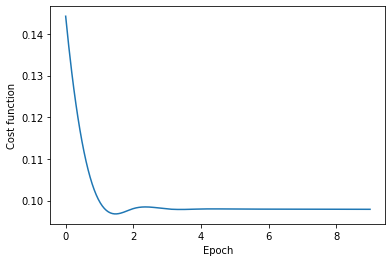

In [ ]:
# Trains the model, prints the R2 at each epoch.
def fit_graph(params, df, regressor, hypothesis, epochs=10):
  cost_axis = []
  for i in range(epochs):
    params = regressor(params, df, hypothesis)
    y_pred = predict(df, hypothesis, params)
    c = cost(df['price'].values, y_pred)
    print('Epoch:', i, '/ Cost: ', c)
    cost_axis.append(c)
  return params, cost_axis

learning_rate = 1e-4
regressor = stochastic_regressor
hypothesis = h2
preprocessor = preprocess_df2
epochs = 10
normalization = z_score_normalization

# Prepare training data.
df = pd.read_csv("diamonds-train.csv")
df = preprocessor(df)
df = normalization(df)

# Define initial params values.
params = {'teta0': 1.0}
for col in df:
  if col == 'price':
    continue
  params[col] = 1.0

# Train.
_, cost_axis = fit_graph(params, df, regressor, hypothesis, epochs)

iter_axis = np.arange(epochs)

# The following code is to make the plot line smoother
from scipy.interpolate import make_interp_spline, BSpline

# 300 represents number of points to make between each epoch
iter_axis_s = np.linspace(min(iter_axis), max(iter_axis), 300) 

spl = make_interp_spline(iter_axis, cost_axis, k=3)  # type: BSpline
cost_axis_s = spl(iter_axis_s)

plt.plot(iter_axis_s, cost_axis_s)
plt.xlabel('Epoch')
plt.ylabel('Cost function')
plt.show()


 > What are the conclusions? What are the actions after such analyses? (1-2 paragraphs)

We can see that after the first epoch there is a notable cost reduction, through epochs 1-3 there is a reduction of `0.001` each time, but after that the cost slowly decreases, staying at `0.0979` most of the time and only going to 0.0978 in the last epoch.

The next actions should be altering the learning rate and increasing the number of epochs, to see if there are any improvements.

4. (3 points) Use different Gradient Descent (GD) learning rates when optimizing. Compare the GD-based solutions with Normal Equation. You should implement your solutions. What are the conclusions?


In [ ]:
# Use different Gradient Descent (GD) learning rates when optimizing:

# First we will turn last question's cell code into a process
def gd_plot():
  regressor = stochastic_regressor
  hypothesis = h2
  preprocessor = preprocess_df2
  epochs = 20
  normalization = z_score_normalization

  # Prepare training data.
  df = pd.read_csv("diamonds-train.csv")
  df = preprocessor(df)
  df = normalization(df)

  # Define initial params values.
  params = {'teta0': 1.0}
  for col in df:
    if col == 'price':
      continue
    params[col] = 1.0

  # Train.
  params, cost_axis = fit_graph(params, df, regressor, hypothesis, epochs)

  iter_axis = np.arange(epochs)

  # 300 represents number of points to make between each epoch
  iter_axis_s = np.linspace(min(iter_axis), max(iter_axis), 300) 

  spl = make_interp_spline(iter_axis, cost_axis, k=3)  # type: BSpline
  cost_axis_s = spl(iter_axis_s)

  plt.plot(iter_axis_s, cost_axis_s)
  plt.xlabel('Epoch')
  plt.ylabel('Cost function')
  plt.show()
  return params

def print_results(params):
  hypothesis = h2
  preprocessor = preprocess_df2
  normalization = z_score_normalization

  # Prepare test data.
  df = pd.read_csv("diamonds-test.csv")
  df = preprocessor(df)
  df = normalization(df)

  # FINAL RESULTS.
  print()
  print('FINAL TEST RESULTS:')
  print(' R^2 score: ', score(params, df, hypothesis))
  y_pred = predict(df, hypothesis, params)
  print(' Mean squared error: ', cost(df['price'].values, y_pred))
  print(' Mean squared error (sklearn): ', mean_squared_error(df['price'].values, y_pred))

Epoch: 0 / Cost:  0.09869006739549956
Epoch: 1 / Cost:  0.09854623716918397
Epoch: 2 / Cost:  0.0984345696587684
Epoch: 3 / Cost:  0.0983477111878437
Epoch: 4 / Cost:  0.09828001089424893
Epoch: 5 / Cost:  0.09822712348275828
Epoch: 6 / Cost:  0.09818570520240572
Epoch: 7 / Cost:  0.09815318092486838
Epoch: 8 / Cost:  0.09812756565713199
Epoch: 9 / Cost:  0.09810732773339664
Epoch: 10 / Cost:  0.09809128392419221
Epoch: 11 / Cost:  0.09807851899079982
Epoch: 12 / Cost:  0.09806832396551911
Epoch: 13 / Cost:  0.09806014877933034
Epoch: 14 / Cost:  0.09805356588473305
Epoch: 15 / Cost:  0.09804824230692959
Epoch: 16 / Cost:  0.09804391815763924
Epoch: 17 / Cost:  0.09804039010592906
Epoch: 18 / Cost:  0.09803749865264384
Epoch: 19 / Cost:  0.09803511832465722


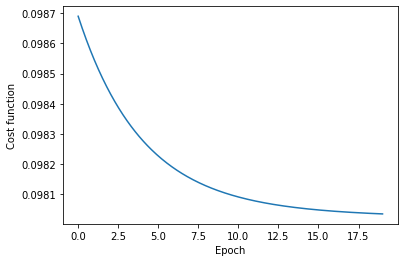


FINAL TEST RESULTS:
 R^2 score:  0.9024252274750569
 Mean squared error:  0.09755525757043856
 Mean squared error (sklearn):  0.09755525757043836


In [ ]:
# Now we can just change the global learning rate before we fit and get the results
learning_rate = 1e-3
params = gd_plot()
print_results(params)

Epoch: 0 / Cost:  0.10639897735884608
Epoch: 1 / Cost:  0.10665285850307461
Epoch: 2 / Cost:  0.10674700093921377
Epoch: 3 / Cost:  0.10677251354459366
Epoch: 4 / Cost:  0.1067790284601166
Epoch: 5 / Cost:  0.10678066893052993
Epoch: 6 / Cost:  0.10678108057523567
Epoch: 7 / Cost:  0.1067811837802244
Epoch: 8 / Cost:  0.10678120964952506
Epoch: 9 / Cost:  0.10678121613355443
Epoch: 10 / Cost:  0.1067812177587288
Epoch: 11 / Cost:  0.1067812181660652
Epoch: 12 / Cost:  0.10678121826815899
Epoch: 13 / Cost:  0.10678121829374902
Epoch: 14 / Cost:  0.10678121830016231
Epoch: 15 / Cost:  0.10678121830177105
Epoch: 16 / Cost:  0.10678121830217209
Epoch: 17 / Cost:  0.10678121830227492
Epoch: 18 / Cost:  0.10678121830230052
Epoch: 19 / Cost:  0.10678121830230727


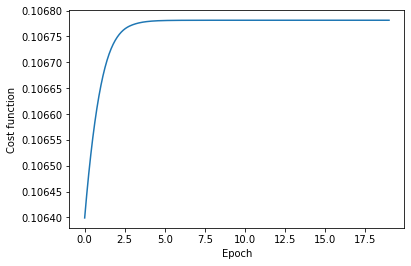


FINAL TEST RESULTS:
 R^2 score:  0.8921587065878156
 Mean squared error:  0.10781972515350269
 Mean squared error (sklearn):  0.10781972515350226


In [ ]:
learning_rate = 1e-2
params = gd_plot()
print_results(params)

Epoch: 0 / Cost:  0.09861555488214782
Epoch: 1 / Cost:  0.09839688578531695
Epoch: 2 / Cost:  0.0982687390901226
Epoch: 3 / Cost:  0.09819356615123648
Epoch: 4 / Cost:  0.09814941126917201
Epoch: 5 / Cost:  0.09812343215375426
Epoch: 6 / Cost:  0.09810811390492168
Epoch: 7 / Cost:  0.0980990565923979
Epoch: 8 / Cost:  0.09809368221383657
Epoch: 9 / Cost:  0.0980904788440985
Epoch: 10 / Cost:  0.09808855869645876
Epoch: 11 / Cost:  0.09808739964547092
Epoch: 12 / Cost:  0.09808669399031866
Epoch: 13 / Cost:  0.09808625991883353
Epoch: 14 / Cost:  0.09808598964186815
Epoch: 15 / Cost:  0.09808581898267195
Epoch: 16 / Cost:  0.09808570952546121
Epoch: 17 / Cost:  0.09808563812072991
Epoch: 18 / Cost:  0.09808559070360653
Epoch: 19 / Cost:  0.09808555864361693


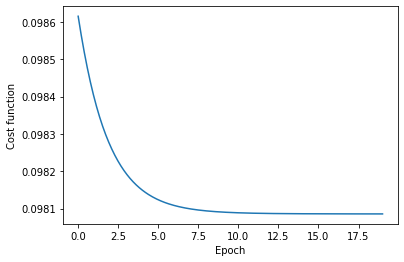


FINAL TEST RESULTS:
 R^2 score:  0.902071209749939
 Mean squared error:  0.09790920449201117
 Mean squared error (sklearn):  0.09790920449201126


In [ ]:
learning_rate = 2e-3
params = gd_plot()
print_results(params)

In [ ]:
# Compare the GD-based solutions (e.g., Batch, SGD, Mini-batch) with Normal Equation. Implement your solution. You cannot use scikit-learn libraries.
preprocess = preprocess_df2
normalization = z_score_normalization

df = pd.read_csv("diamonds-train.csv")
df = preprocess(df)
df = normalization(df)
df.insert(0, 'teta0', np.ones((len(df.index), 1), dtype=int))
print(df)
X = df.drop(['price'], axis=1).values
y = df['price'].values

# NORMAL EQUATION
start = timer()
X_t = np.transpose(X)
params_values = np.dot(np.dot(np.linalg.inv(np.dot(X_t, X)), X_t), y)
end = timer()

headers = list(df.drop(['price'], axis=1))
params = dict(zip(headers, params_values))
print('Final values for tetas:', params)

# Prepare test data.
df = pd.read_csv("diamonds-test.csv")
df = preprocess(df)
df = normalization(df)

# FINAL RESULTS.
print('Elapsed training time: ', end - start, ' seconds.')
print('R^2 score: ', score(params, df, hypothesis))
y_pred = predict(df, hypothesis, params)
print('Mean squared error: ', cost(df['price'].values, y_pred))
print('Mean squared error (sklearn): ', mean_squared_error(df['price'].values, y_pred))

       teta0     carat       cut  ...     depth     table     price
0          1  1.734793  0.980673  ...  0.248643 -1.097975  1.646820
1          1 -1.050775  0.085208  ... -2.066790  1.136679 -0.842504
2          1  1.207223  0.980673  ... -1.505473 -0.204113  1.934695
3          1 -0.987467 -2.601184  ...  2.353583  0.689748 -0.755239
4          1 -1.008570 -0.810256  ... -2.066790  2.030540 -0.835483
...      ...       ...       ...  ...       ...       ...       ...
44995      1  0.510831  0.980673  ...  0.038149 -1.097975  0.516631
44996      1  0.447523 -0.810256  ...  0.950290 -1.544905 -0.029029
44997      1 -0.628720  0.980673  ... -0.453003 -0.651044 -0.575943
44998      1 -0.987467  0.980673  ...  0.318808 -1.544905 -0.842253
44999      1 -1.029672  0.085208  ...  0.038149  0.689748 -0.789342

[45000 rows x 9 columns]
Final values for tetas: {'teta0': 2.809384669344439e-15, 'carat': 0.8332114811231538, 'cut': 0.03178080717379272, 'color': 0.1267077805326195, 'clarity': 0.21

> What are the conclusions? (2-4 paragraphs)

Firstly, when changing the learning rates, we probably found our limit before diverging, at least for our current model. When using a learning rate of `1e-3` we already saw better results in the first epoch, achieving the `0.098` mark right away. However, this time the gradient descent appeared to be a lot slower than before, reaching the `0.098035` of cost at the last epoch. It is important to notice that we also increased the number of epochs to 20 to allow the cost to reduce even more. Interestingly enough, when using the test data our cost reached `0.097`, a better result than our training showed.

However, when using a learning rate of `1e-2` we immediately noticed the cost reach `0.106` and start increasing, showing that the model would not converge. Even though this learning rate prevented a gradient descent when testing, the R^2 score remained at a high `0.892` and the cost was `0.107`, a relatively "good" error value. The reason for this could be due to the slow increase in the cost function that prevented worse results.

The last training using a learning rate of `2e-3` showed that the "limit" could be at the 10^3 scale. A test (not in this notebook) made using `6e-3` and the results were similar to the `1e-2` test. This test also arrived at similar results as the first one, with a slightly worse R^2 score.

Finally, using the Normal Equation was much faster and arrived at almost the same, if not better, results. With the Normal Equation, we only spent `0.005` seconds training to arrive at a `0.9026` R^2 score and a `0.0972` mean squared error. As we did until now, we also normalized the data before calculating the theta matrix.